<a href="https://colab.research.google.com/github/PlaZMaD/ml_miem_2024/blob/main/Seminar_10_0_Neural_Networks_TSNE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Семинар 10. Часть 1. Нейронные сети. Обучение без учителя. TSNE
----------

(использованы материалы курса [Машинное обучение в Питоне](https://www.hse.ru/edu/courses/450323352))

На семинаре мы рассмотрим несколько методов снижения размерности и реализуем с нуля нейронную сеть с прямой связью (FNN).

Для этого мы будем использовать [Fashion-MNIST набор данных](https://github.com/zalandoresearch/fashion-mnist), который содержит изображения одежды с десятью различными категориями.

## Предобработка данных

In [ ]:
%%capture
# Загрузка данных в Google Drive
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz

In [ ]:
# Импорт необходимых библиотек и чтение данных
import os, gzip, numpy as np, matplotlib.pyplot as plt, seaborn as sns
sns.set()

def load_mnist(path, kind='train'):
    """Function to load mnist-like dataset
    (code from https://github.com/zalandoresearch/fashion-mnist/blob/master/utils/mnist_reader.py)
    """

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

print("Loading dataset...")
train_images, train_labels = load_mnist('.')
test_images, test_labels = load_mnist('.', 't10k')
label_names = [
               'T-shirt', 'Trouser', 'Pullover',
               'Dress', 'Coat', 'Sandal', 'Shirt',
               'Sneaker', 'Bag', 'Ankle boot'
               ]
print("Normalizing data...")
train_images = train_images.astype('float')
fmnist_mean, fmnist_std = train_images.mean(), train_images.mean(axis=1).std()
train_images = (train_images - fmnist_mean) / fmnist_std
print("Fashion MNIST stats:", fmnist_mean, fmnist_std)
test_images = (test_images - fmnist_mean) / fmnist_std
print("Fashion MNIST train/test shapes", train_images.shape, test_images.shape)
print("Done!")

Давайте визуализируем несколько примеров из наших данных:

In [ ]:
def show_samples(images, labels=None, n_samples=36, np_seed=None):
    if np_seed is not None:
        np.random.seed(np_seed)
    r_indices = np.random.randint(0, images.shape[0], size=n_samples)

    plt.figure(figsize=(12, 12))
    plt.suptitle("Fashion-MNIST samples", fontsize=30)
    n_rows = int(n_samples ** 0.5)
    for j, idx in enumerate(r_indices):
        c_row, c_col = j // n_rows, j % n_rows
        plt.subplot(n_rows, n_samples // n_rows, j + 1)
        if labels is not None:
            plt.title(label_names[labels[idx]])
        plt.imshow(
            images[idx].reshape(28, 28), cmap='gray',
            vmin=images.min(), vmax=images.max()
        )
        plt.axis('off')
    plt.show()

show_samples(train_images, train_labels, np_seed=42)

Мы видим, что все изображения имеют пониженное разрешение и представлены в градациях серого. Кроме того, есть несколько сильно пересекающихся классов (например, футболка и рубашка)

## Снижение размерности

Несмотря на низкое разрешение, каждое наблюдение является точкой в $28 \times 28 = 784$-мерном пространстве, что довольно много!

Давайте попробуем использовать различные методы снижения размерности для визуализации.

### Случайные признаки

In [ ]:
# Для визуализации мы будем использовать только первые k образцов
k = 5000
show_images, show_labels = train_images[:k], train_labels[:k]

def show_2d_viz(features, labels=None, title=None):
    """A utility function that shows given points in 2d space"""
    if features.shape[1] != 2:
        assert False, "Need two features only for visualization"
    plt.figure(figsize=(14, 6))
    if title is not None:
        plt.title(title, fontsize=30)
    if labels is not None:
        plt.scatter(
            features[:, 0], features[:, 1], c=labels, s=20,
            cmap='coolwarm'
        )
    else:
        plt.scatter(features[:, 0], features[:, 1])
    plt.show()

show_2d_viz(show_images[:,5:7], show_labels, '2 random input features')

### Анализ главных компонент (PCA)

(Метод максимальной дисперсии)

In [ ]:
from sklearn.decomposition import PCA
show_pca = PCA(n_components=2).fit_transform(show_images)
show_2d_viz(show_pca, show_labels, 'PCA')

In [ ]:
show_pca.shape

### Линейный дискриминантный анализ (LDA)

Напомним, что модель LDA дает следующий логарифм вероятности классов:

$\log P(y = k|x) = -\frac{1}{2}(x - \mu_k)^T\Sigma^{-1}(x - \mu_k) + \log \pi_k + C,$

где $\mu_k$ - средние значения классов, $\pi_k$ - априорные вероятности классов, $\Sigma$ - общая ковариационная матрица, а $C$ - некоторая константа.

Таким образом, предсказанный класс зависит от расстояния от $x$ до $\mu_k$ --- с равномерной априорной вероятностью, чем ближе мы находимся к одному из центров класса, тем увереннее мы его предсказываем.

Мы можем рассматривать это как проецирование входных данных на $(K - 1)$-мерное подпространство ($K$ - число классов), охватываемое $\{\mu_j\}_{j=1}^K$ и поиск ближайшего центра.

Кроме того, мы можем выбрать еще меньшую размерность, применив PCA к $\mu_j$ и затем спроецировав входные данные.

Это дает нам возможность уменьшить размерность с помощью метода классификации.

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
show_lda = LinearDiscriminantAnalysis(n_components=2).fit_transform(
    show_images, show_labels
)
show_2d_viz(show_lda, show_labels, 'LDA')

### t-SNE

Стохастическое вложение соседей с t-распределением (англ. t-distributed Stochastic Neighbor Embedding, t-SNE - это продвинутый метод визуализации данных.

Суть его заключается в том, что мы хотим встроить отдельные точки $\{x_j\}_{j=1}^N$ в низкоразмерное пространство таким образом, чтобы все парные расстояния между вкраплениями $\{e_j\}_{j=1}^N$ были как можно ближе ко всем парным расстояниям в исходном пространстве.

Для этого мы каким-то образом инициализируем вкрапления и затем последовательно обновляем их, чтобы уменьшить разрыв между парными расстояниями.

Итак, мы определяем в исходном пространстве попарное сходство между $x_i$ и $x_j$ как:

$$p_{i j} = \frac{p_{j|i} + p_{i|j}}{2N}, \text{где}\ p_{j|i} = \frac{\exp{(-\frac{\|x_i - x_j\|^2}{2\sigma_i})}}{\sum_{k \neq i}exp(-\frac{\|x_i - x_k\|^2}{2\sigma_k})}$$

и затем строим $d$-мерную карту $\{e_j\}_{j=1}^N$, чтобы отразить сходство $p_{ij}$ как можно лучше, определив сходство во вложенном пространстве между $e_i$ и $e_j$ как:

$$q_{i,j} = \frac{(1 + \|e_i - e_j\|^2)^{-1}}{\sum_{k}\sum_{l \neq k}(1 + \|e_l - e_k\|^2)^{-1}}.$$

Затем минимизируем расхождение Куллбэка-Лейбнера между распределениями $p$ и $q$:

$$\ell(q) = KL(p || q) = \sum_{i\neq j}p_{ij}\log\frac{p_{ij}}{q_{ij}}.$$



In [ ]:
?TSNE

In [ ]:
from sklearn.manifold import TSNE

show_tsne = TSNE(
    n_components=2, init='pca',
    random_state=0, verbose=1
).fit_transform(show_images)

show_2d_viz(show_tsne, show_labels, 't-SNE')

Обратите внимание, что для вычисления t-SNE на всех данных потребуется несколько часов на CPU, вот [авторский результат](https://github.com/zalandoresearch/fashion-mnist/blob/master/doc/img/34d72c08.png):

<img src='https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/doc/img/34d72c08.png' width=700/>

## Baseline классификатор

Поскольку LDA имеет ограничение на $\leq 10$ признаков, а t-SNE неприменим для извлечения признаков, мы будем использовать стандартный PCA с RandomForest поверх него.

In [ ]:
?PCA

In [ ]:
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

pca_model = PCA(n_components=64).fit(train_images)

rf_clf = RandomForestClassifier()
rf_clf = rf_clf.fit(pca_model.transform(train_images), train_labels)

rf_predictions = rf_clf.predict(pca_model.transform(test_images))

print("Baseline result (PCA + RF):")
print(classification_report(test_labels, rf_predictions))

# Глубокое обучение: построение нейронной сети "с нуля" (`python` + `numpy`)


Глубокая нейронная сеть из 2 слоев представляет собой **вложенную функцию**, как это:

$$y = f(x) = \mathrm{activation}(\mathrm{layer}_2(\mathrm{activation}(\mathrm{layer}_1(x)))),$$ или другими словами $$z = \mathrm{activation}(layer_1(x)),$$
$$y = \mathrm{activation}(\mathrm{layer}_2(z))).$$

В случае классификации вход $x$ - это вектор (или матрица, или тензор) входных признаков. Выход $y$ - это вероятности каждого класса.

Простейшим видом слоя является плотный слой, также называемый линейным:

$$\mathrm{layer}_1(x) = xW_1 + b_1$$

Здесь $W_1$ - матрица *весов* слоя, $b_1$ - *bias*, постоянная величина. Это просто **линейная регрессия**.

Линейная регрессия не годится для такой задачи, как классификация изображений, нам нужна более сложная функция. Для этого мы оборачиваем линейный слой каким-либо видом **нелинейной активации**.

Одним из наиболее популярных вариантов является ReLU:

$$\mathrm{activation}(x) = \mathrm{ReLU}(x) = \mathrm{max}(0, x)$$

Напомним, что логистическая регрессия - это линейная модель, обернутая в сигмоидную функцию. Поэтому если вы возьмете сигмоидную активацию над линейным слоем $\mathrm{sigmoid}(\mathrm{layer}(x))$, то получите **логистическую регрессию:**

$$y = \mathrm{activation}(\mathrm{layer}_1(x)) = \mathrm{sigmoid}(xW_1 + b_1).$$

Трудности возникают при многократном повторении этого процесса. В результате получается очень сложная функция, которая способна моделировать очень сложные зависимости.

In [ ]:
x = np.linspace(-1, 1, 100)
plt.plot(x, np.maximum(0, x), label='ReLU')
plt.title('ReLU acitvation function')
plt.xlabel('$x$')
plt.ylabel('$relu(x)$')
plt.show()

### Нейронные сети как множество преобразований признаков

Один из способов представить себе глубинные нейронные сети - это рассматривать их как **вложенные экстракторы признаков**.

Первый слой и активация, $\mathrm{activation}(\mathrm{layer}_1(x))$, обучает нелинейному отображению из данных большой размерности $x$ в некоторое представление другой размерности (более низкой или более высокой). Второй слой $\mathrm{activation}(\mathrm{layer}_2(\dots))$ обучается отображению от предыдущего представления к новому.

По сути, первый слой учится извлекать полезные характеристики из входных данных. Второй слой учится извлекать полезные свойства из предыдущих полезных свойств.


### Но как алгоритм может научиться чему-то полезному? Введем обратное распространение.

В сложной функции DNN мы можем только **изменять веса и смещения**. Наша цель - изменить их таким образом, чтобы минимизировать потери (ошибки) $L(y, y')$, где $y$ - истинные метки, а $y'$ - наши предсказания.

**Отрицательные градиенты функции потерь говорят нам, как изменить веса, чтобы минимизировать потери*.

Это требует, чтобы функция потерь была **дифференцируемой.**

Для классификации функция потерь - это кросс-энтропийная потеря (log-loss):
$$L(y, p) = -\sum_{c=1}^My_{i,c}\log(p_{i,c})$$

Где $M$ - количество классов, $y_{i,c} = 1$, если наблюдение $i$ принадлежит классу $c$, $p_{i,c}$ - предсказанная вероятность принадлежности $i$ к классу $c$.

В случае двух классов это просто отрицательное логарифмическое правдоподобие:
$$L(y, p) = -{(y\log(p) + (1 - y)\log(1 - p))}$$

Таким образом, для некоторых данных $x$ градиент потерь подскажет нам, как изменить нашу сеть, чтобы потери были меньше.
Рассмотрим нашу сеть как $f$. Дифференциал потерь относительно выходов сети говорит нам, как должны измениться выходы, чтобы потери стали меньше: $$\frac{\partial L}{\partial f(x)}$$

Однако это не говорит нам, как обновлять веса.

Вспомним [правило цепочки](https://www.khanacademy.org/math/ap-calculus-ab/ab-differentiation-2-new/ab-3-1a/a/chain-rule-review):
$$\frac{d}{dx} [ f(g(x)) ] = f'(g(x))g'(x)$$

Это позволяет нам дифференцировать **составные функции**. Нейронная сеть - это составная функция, поэтому...

Оказывается, мы можем использовать **правило цепочки** для обновления каждого веса! Это называется **обратным распространением**: мы начинаем с градиентов функции потерь и распространяем их назад, "разворачивая" градиенты.

Наконец, когда мы знаем градиенты $L$ относительно весов $W$, мы обновляем их методом градиентного спуска:

$$W_{t+1} = W_{t} - \lambda \cdot \frac{\partial L}{\partial W_{t}}$$

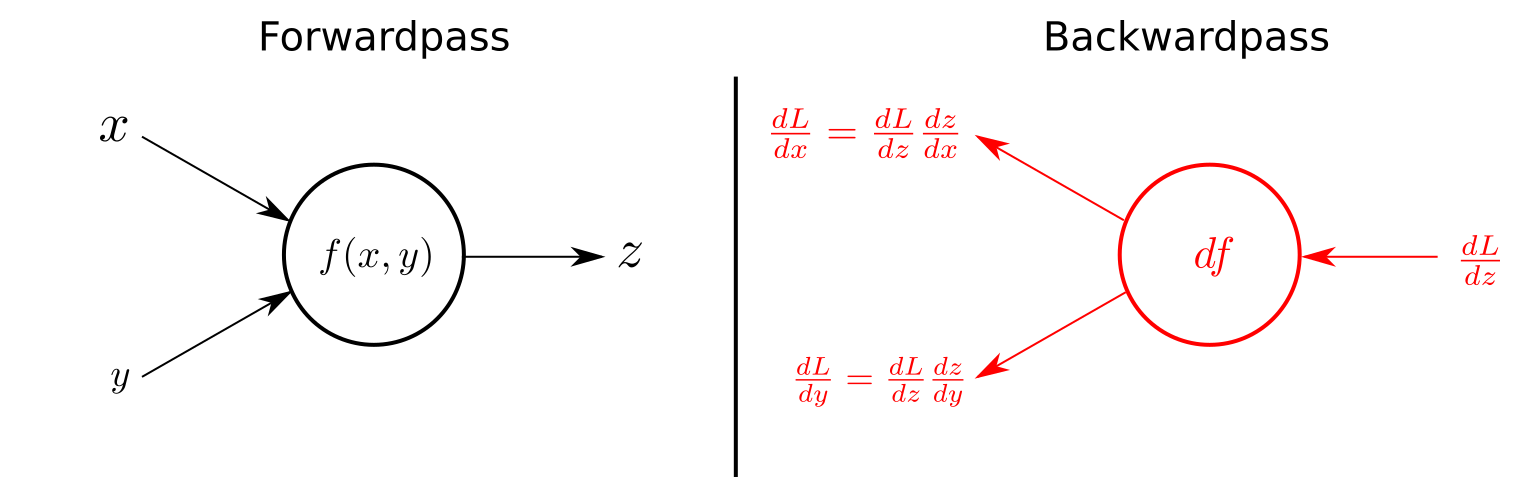

[Хорошее объяснение как вывести правила обновления весов для полностью связанных слоев](https://towardsdatascience.com/under-the-hood-of-neural-networks-part-1-fully-connected-5223b7f78528)

### Основной класс

In [ ]:
class Module:
    """
    Each layer in neural network is inhereted from it and
    is capable of performing two things:

    - Process input to get output:           output = layer.forward(input)

    - Propagate gradients through itself:    grad_input = layer.backward(input, grad_output)

    Some layers also have learnable parameters which they update during layer.backward.
    """
    def forward(self, input):
        """
        Takes input data of shape [batch, input_dim],
        returns output data of shape [batch, output_dim]
        """
        # A dummy layer just returns whatever it gets as input.
        return input

    def __call__(self, input):
        return self.forward(input)

    def __repr__(self):
        return "Identity"

    def backward(self, input, grad_output):
        """
        Performs a backpropagation step through the layer, with respect to the given input.

        To compute loss gradients w.r.t input, you need to apply chain rule (backprop):

        d loss / d x  = (d loss / d layer) * (d layer / d x)

        Luckily, you already receive d loss / d layer as input, so you only need to multiply it by d layer / d x.

        If your layer has parameters (e.g. dense layer), you also need to update them here using d loss / d layer
        """
        # The gradient of a dummy layer is precisely grad_output, but we'll write it more explicitly
        num_units = input.shape[1]

        d_layer_d_input = np.eye(num_units)

        return np.dot(grad_output, d_layer_d_input) # chain rule

In [ ]:
?np.eye

### Нелинейность ReLU

In [ ]:
class BaseReLU(Module):
    """An elementwise nonlinearity layer: f(X) = (X if X > 0 else 0)"""
    def __repr__(self):
        return "ReLU"

    def forward(self, input):
        """Elementwise nonlinear transform"""
        return input * (input > 0)

class ReLU(BaseReLU):
    def backward(self, input, grad_output):
        """Compute gradient of loss w.r.t. ReLU input"""
        # Напишите Ваш код
        relu_grad = input > 0
        return relu_grad * grad_output


### Линейный слой

In [ ]:
class BaseLinear(Module):
    """A linear layer to perform affine transform: f(x) = <x, W> + b"""
    def __init__(self, input_dim, output_dim, learning_rate=0.1):
        # Note! We usually don't specify learning rate in modules - that's
        # just for convenience in our example
        self.learning_rate = learning_rate

        # A dummy weight initialization. For a more advanced version see
        # https://arxiv.org/abs/1502.01852
        self.weight = 0.01 * np.random.randn(input_dim, output_dim)
        self.bias = np.zeros(output_dim)

    def forward(self, input):
        """Linear transform
        input shape: [batch_size, input_dim]

        Return shape: [batch_size, output_dim]
        """
        return input @ self.weight + self.bias

    def __repr__(self):
        return "Linear(%d, %d)" % (self.weight.shape[0], self.weight.shape[1])

class Linear(BaseLinear):
    def backward(self, input, grad_output):
        """Get gradients and apply chain rule for linear transformation
        input shape: [batch_size, input_dim]
        grad_output shape: [batch_size, output_dim]

        Return shape: [batch_size, input_dim]
        """

        # Chain rule: dF(Xw + b) / dX = dF / d(Xw + b) * w^T
        grad_input = grad_output @ self.weight.T

        # Chain rule: dF(Xw + b) / dW = dF / d(Xw + b) * X
        # + sum across batch
        #print(self, input.shape, grad_output.shape)
        weight_grad = input.T @ grad_output

        # Chain rule: dF(xW + b) / db = dF / d(Xw + b)
        # + sum across batch
        bias_grad = grad_output.sum(axis=0)

        assert weight_grad.shape == self.weight.shape, "weight grad has invalid shapes"
        assert bias_grad.shape == self.bias.shape, "bias grad has invalid shapes"

        # Perform gradient descent step to improve model quality
        self.weight -= self.learning_rate * weight_grad
        self.bias -= self.learning_rate * bias_grad

        return grad_input

### Softmax и кросс-энтропийная функция потерь

In [ ]:
class CrossEntropyLoss(Module):
    """A module that implements cross entropy loss. Can be implemented
    as two separate functions as well"""
    def __call__(self, logits, ground_truth):
        """Get crossentropy loss from unnormalized model predictions.
        Here ``ground_truth`` correspond to class labels (e.g. [5, 9, ...])
        """
        logits_for_gt = logits[np.arange(logits.shape[0]), ground_truth]

        crossentropy = -logits_for_gt + np.log(np.sum(np.exp(logits), axis=1))
        return crossentropy

    def __repr__(self):
        print("Crossentropy loss (note: Softmax included!)")

    def backward(self, logits, ground_truth):
        """Get crossentropy loss gradient from unnormalized model predictions"""

        # Get actual prediction probs
        predictions = np.exp(logits) / np.exp(logits).sum(1, keepdims=True)

        # Subtract one in logits that match ground truth labels
        predictions[np.arange(logits.shape[0]), ground_truth] -= 1.0
        # Normalize
        return predictions / logits.shape[0]


### Последовательный слой

In [ ]:
class Sequential(Module):
    """A module for combining layers into a single class - Network"""
    def __init__(self, layers):
        self.layers = layers
        self.layers_inputs = []

    def forward(self, input):
        """The forward call iterates across layers sequentially
        and caches their inputs"""
        self.layers_inputs = []

        for j, layer in enumerate(self.layers):
            self.layers_inputs.append(input)
            output = layer(input)
            if j < len(self.layers) - 1:
                input = output

        return output

    def __repr__(self):
        for layer in self.layers:
            print(layer)

    def backward(self, grad_output):
        """The backward call iterates across layers in reversed order
        and uses accumulated gradient + layer input to update weights and
        pass gradient further
        """
        for j, layer in reversed(list(enumerate(self.layers))):
            grad_output = layer.backward(
                self.layers_inputs[j], grad_output
            )

### Обучение

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    train_images, train_labels, test_size=0.05
)
print("Train/val sizes are", X_train.shape, X_val.shape)

In [ ]:
from sklearn.metrics import accuracy_score

simple_network = Sequential([
    Linear(X_train.shape[1], 100),
    ReLU(),
    Linear(100, 200),
    ReLU(),
    Linear(200, 10)
])

def get_predictions(network, images):
    # A simple function to get model predictions
    logits = network(images)
    return logits.argmax(axis=1)

def train_step(network, X_batch, y_batch, loss_cls=None):
    """Perform single forward-backward passes and update network weights"""
    assert loss_cls is not None, "Output loss class is required for training"
    logits = network(X_batch)

    # Compute the loss and initial gradient
    loss = loss_cls(logits, y_batch)
    loss_grad = loss_cls.backward(logits, y_batch)
    # Backprop this gradient into network
    network.backward(loss_grad)

    return loss.mean()

def eval_step(network, X_train, y_train, X_val, y_val):
    """Evaluate model accuracy on train/val data"""
    train_preds = get_predictions(network, X_train)
    val_preds = get_predictions(network, X_val)

    train_acc = accuracy_score(y_train, train_preds)
    val_acc = accuracy_score(y_val, val_preds)
    return train_acc, val_acc

def iterated_data(images, labels, batch_size, shuffle=False):
    """Iterate through minibatches of data with a given batch size"""
    assert len(images) == len(labels), "Num images and labels should match"

    indices = np.random.permutation(len(images)) if shuffle else np.arange(len(images))
    for start_idx in range(0, len(indices), batch_size):
        end_idx = min(start_idx + batch_size, len(indices))
        selected_indices = indices[start_idx:end_idx]
        yield images[selected_indices], labels[selected_indices]


In [ ]:
def train_network(
    network, X_train, y_train, X_val, y_val, batch_size=32,
    epochs=25, verbose=True
):
    loss_cls = CrossEntropyLoss()
    train_accs, val_accs = [], []

    for e in range(epochs):
        for X_batch, y_batch in iterated_data(X_train, y_train, batch_size, True):
            train_step(network, X_batch, y_batch, loss_cls)
        train_acc, val_acc = eval_step(network, X_train, y_train, X_val, y_val)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        if verbose:
            print(
                "EPOCH %d train accuracy %.3f val accuracy %.3f" % (
                    e, train_acc, val_acc
                )
            )
    return train_accs, val_accs

np_stats = train_network(simple_network, X_train, y_train, X_val, y_val)

In [ ]:
print(
    classification_report(
        test_labels,
        get_predictions(simple_network, test_images)
    )
)

## Реализация аналогичной сети в Pytorch

Приведенный ниже код реализует то же самое, что мы делали в чистом `numpy`, но с использованием библиотеки PyTorch.

In [ ]:
?SGD

In [ ]:
import torch, torch.nn as nn
from torch.optim import SGD

torch_network = nn.Sequential(*[
    nn.Linear(28*28, 100),
    nn.ReLU(),
    nn.Linear(100, 200),
    nn.ReLU(),
    nn.Linear(200, 10)
])

network_optimizer = SGD(
    torch_network.parameters(), lr=1e-2, weight_decay=1e-3,

)

In [ ]:
loss_cls = nn.CrossEntropyLoss()
new_train_accs, new_val_accs = [], []

for e in range(25):
    for X_batch, y_batch in iterated_data(X_train, y_train, 32, True):
        X_batch, y_batch = torch.FloatTensor(X_batch), torch.LongTensor(y_batch)

        network_optimizer.zero_grad()

        y_pred = torch_network(X_batch)
        loss = loss_cls(y_pred, y_batch)
        loss.backward()

        network_optimizer.step()

    train_acc, val_acc = eval_step(
        torch_network,
        torch.FloatTensor(X_train), torch.LongTensor(y_train),
        torch.FloatTensor(X_val),  torch.LongTensor(y_val)
    )
    new_train_accs.append(train_acc)
    new_val_accs.append(val_acc)
    print(
        "EPOCH %d train accuracy %.3f val accuracy %.3f" % (
            e, train_acc, val_acc
        )
    )



In [ ]:
print(
    classification_report(
        test_labels,
        get_predictions(simple_network, test_images)
    )
)

# Самостоятельная работа (30")

Попробуйте применить известные вам модели к набору данных [SVHN](http://ufldl.stanford.edu/housenumbers/).

Затем обсудим результаты.

In [ ]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [ ]:
!wget http://ufldl.stanford.edu/housenumbers/train_32x32.mat
!wget http://ufldl.stanford.edu/housenumbers/test_32x32.mat

In [ ]:
ll

In [ ]:
def load_data(path):
    """ Helper function for loading a MAT-File"""
    data = loadmat(path)
    return data['X'], data['y']

X_train, y_train = load_data('train_32x32.mat')
X_test, y_test = load_data('test_32x32.mat')

print("Train:", X_train.shape, y_train.shape)
print("Test:", X_test.shape, y_test.shape)

In [ ]:
X_train, y_train = X_train.transpose((3,0,1,2)), y_train[:,0]
X_test, y_test = X_test.transpose((3,0,1,2)), y_test[:,0]

In [ ]:
def plot_images(img, labels, nrows, ncols):

    fig, axes = plt.subplots(nrows, ncols)
    for i, ax in enumerate(axes.flat):
        if img[i].shape == (32, 32, 3):
            ax.imshow(img[i])
        else:
            ax.imshow(img[i,:,:,0])
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_title(labels[i])

In [ ]:
plot_images(X_train, y_train, 3, 4)

In [ ]:
print(np.unique(y_train))

In [ ]:
y_train[y_train == 10] = 0
y_test[y_test == 10] = 0

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.13, random_state=7)

In [ ]:
y_train.shape, y_val.shape, y_test.shape

In [ ]:
def rgb2gray(images):
    return np.expand_dims(np.dot(images, [0.33, 0.33, 0.33]), axis=3)

In [ ]:
train_greyscale = rgb2gray(X_train).astype(np.float32)
test_greyscale = rgb2gray(X_test).astype(np.float32)
val_greyscale = rgb2gray(X_val).astype(np.float32)

In [ ]:
# Calculate the mean on the training data
train_mean = np.mean(train_greyscale, axis=0)

# Calculate the std on the training data
train_std = np.std(train_greyscale, axis=0)

# Subtract it equally from all splits
train_greyscale_norm = (train_greyscale - train_mean) / train_std
test_greyscale_norm = (test_greyscale - train_mean)  / train_std
val_greyscale_norm = (val_greyscale - train_mean) / train_std

In [ ]:
import matplotlib.pyplot as plt

plot_images(train_greyscale_norm, y_train, 3, 4)

In [ ]:
X_train = np.squeeze(train_greyscale_norm, axis=-1).reshape(63733, 1024)
X_test = np.squeeze(test_greyscale_norm, axis=-1).reshape(26032, 1024)
X_val = np.squeeze(val_greyscale_norm, axis=-1).reshape(9524, 1024)

In [ ]:
import torch, torch.nn as nn
from torch.optim import SGD

torch_network = nn.Sequential(*[
    nn.Linear(32*32, 100),
    nn.ReLU(),
    nn.Linear(100, 200),
    nn.ReLU(),
    nn.Linear(200, 10)
])

network_optimizer = SGD(
    torch_network.parameters(), lr=1e-2, weight_decay=1e-3,

)

In [ ]:
loss_cls = nn.CrossEntropyLoss()
new_train_accs, new_val_accs = [], []

for e in range(20):
    for X_batch, y_batch in iterated_data(X_train, y_train, 32, True):
        X_batch, y_batch = torch.FloatTensor(X_batch), torch.LongTensor(y_batch)

        network_optimizer.zero_grad()

        y_pred = torch_network(X_batch)
        loss = loss_cls(y_pred, y_batch)
        loss.backward()

        network_optimizer.step()

    train_acc, val_acc = eval_step(
        torch_network,
        torch.FloatTensor(X_train), torch.LongTensor(y_train),
        torch.FloatTensor(X_val),  torch.LongTensor(y_val)
    )
    new_train_accs.append(train_acc)
    new_val_accs.append(val_acc)
    print(
        "EPOCH %d train accuracy %.3f val accuracy %.3f" % (
            e, train_acc, val_acc
        )
    )